## Proof of Concept on Abstracts Segmentation with NLP

**Objective:** The objective of this notebook is to conduct an initial exploration of the data using classical data science and machine learning methods to determine the best approach to tackle the classification problem.

- Different methods can be used for measuring semantic similarity:

  - Word counting (counting or "Term Frequency-Inverse Document Frequency")
  - Language model-based methods (e.g., Word2Vec)
  - Neural network-based methods (e.g., BERT)
  - Distance method (e.g., cosine similarity)

  For this exercise, we decided to use a simple method based on the KMeans clustering algorithm executed on the TF-IDF transformation of the total set of words in the text corpus. The calculation generates a "relative weight" value for each word, and with this set of matrices (each abstract in words with their weights), it calculates which ones are most similar in semantic terms by count and relative weight of words. In other words,



**Hypothesis:** Abstracts in which the same words have a higher relative weight probably discuss similar topics and can be grouped as a thematic area according to their keywords.


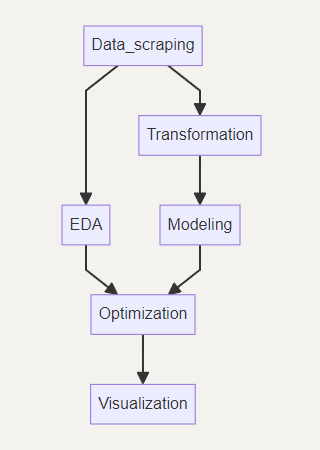

#### Mapear los archivos

In [1]:
## IMPORTS
import sys
sys.path.append('C:\\Users\\user\\Desktop\\Globant\\nfs-npl-globant-test-2024\\src\\data')
sys.path.append('C:\\Users\\user\\Desktop\\Globant\\nfs-npl-globant-test-2024\\src\\features')

In [2]:
## IMPORTS
import os
import re
import json
import random
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from clustering import Cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

path = 'C:/Users/user/Desktop/Globant/nfs-npl-globant-test-2024/data/raw/' # Agregate de dir of your data in .xml

c:\Users\user\Desktop\Globant\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## Help Functions
def abstract_names_function(path):
    if not os.path.exists(path):
        return "El directorio no existe."
    
    nombres_de_archivos = [archivo for archivo in os.listdir(path) if os.path.isfile(os.path.join(path, archivo))]

    return nombres_de_archivos

def abstract_sampler(full_list, n):

    if n > len(full_list):
        return "Error: n es mayor que el número de elementos en la lista."
    
    muestra_seleccionada = random.sample(full_list, n)
    
    return muestra_seleccionada

def extract_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    title = root.find('.//AwardTitle').text if root.find('.//AwardTitle') is not None else "No Title"
    abstract = root.find('.//AbstractNarration').text if root.find('.//AbstractNarration') is not None else "No Abstract"
    
    return {
        "title": title,
        "abstract": abstract
    }

def clean_text(text):
    if pd.isna(text):
        return "" 

    # Cleaning
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [4]:
## Search al docs in the dir
archivos_full = abstract_names_function(path)
print(len(archivos_full))

13300


In [5]:
# Sampling
n = int(13300*0.75) ## 75% of data to training data sample

muestra = abstract_sampler(archivos_full, n)

print("archivos: ", len(muestra))
print("array_view: ",muestra[:10])

archivos:  9975
array_view:  ['2053373.xml', '2022278.xml', '2038439.xml', '2015317.xml', '2015293.xml', '2033131.xml', '2032610.xml', '2046842.xml', '2001738.xml', '2010176.xml']


In [6]:
## Creating test sample
set_orig = set(archivos_full)
set_sample = set(muestra)

set_test_sample = set_orig-set_sample
test_sample = list(set_test_sample)

print("archivos: ", len(test_sample))
print("array_view: ",test_sample[:10])

archivos:  3325
array_view:  ['2014895.xml', '2026740.xml', '2029789.xml', '2038963.xml', '2009554.xml', '2045058.xml', '2046746.xml', '2019000.xml', '2029028.xml', '2034557.xml']


In [ ]:
# Save original data training names
with open('./data/processed/train_names.json', 'w') as f:
    json.dump(muestra, f)

with open('./data/processed/test_names.json', 'w') as f:
    json.dump(test_sample, f)

# with open('./data/processed/test_names.json', 'r') as f:
#     lista = json.load(f)

In [7]:
path + muestra[0]

'C:/Users/user/Desktop/Globant/nfs-npl-globant-test-2024/data/raw/2053373.xml'

#### Ingestar la muestra

In [8]:
# processing data
data_list = [extract_data(path+file) for file in muestra]
df_abstracts = pd.DataFrame(data_list)

display(df_abstracts.head())

,title,abstract
0,LEAP-HI: Re-Engineering for Adaptable Lives an...,Maximizing efficiency has been the driving for...
1,CBET-EPSRC Efficient Surrogate Modeling for Su...,Water management in densely populated coastal ...
2,CAREER: Biochar Systems for Sustainable Applic...,Biochar is a carbon-rich solid byproduct of th...
3,"NeuroNex: Communication, Coordination, and Con...",Despite the apparent differences between anima...
4,An AGEP Historically Black Universities Model ...,The Historically Black Colleges and Universiti...


In [9]:
# Cleaning abstracts
df_abstracts['clean_abstract'] = df_abstracts['abstract'].apply(clean_text)

display(df_abstracts.head())

,title,abstract,clean_abstract
0,LEAP-HI: Re-Engineering for Adaptable Lives an...,Maximizing efficiency has been the driving for...,maximizing efficiency has been the driving for...
1,CBET-EPSRC Efficient Surrogate Modeling for Su...,Water management in densely populated coastal ...,water management in densely populated coastal ...
2,CAREER: Biochar Systems for Sustainable Applic...,Biochar is a carbon-rich solid byproduct of th...,biochar is a carbonrich solid byproduct of the...
3,"NeuroNex: Communication, Coordination, and Con...",Despite the apparent differences between anima...,despite the apparent differences between anima...
4,An AGEP Historically Black Universities Model ...,The Historically Black Colleges and Universiti...,the historically black colleges and universiti...


In [13]:
## Saving data
# df_abstracts.to_csv('./Data-names/train_data.csv', index=False)

# Importar data
df_abstracts = pd.read_csv('C:/Users/user/Desktop/Globant/nfs-npl-globant-test-2024/data/processed/train_data.csv').fillna("")
df_abstracts.drop(['cluster', 'abstract_length'], axis=1, inplace=True) #Limpieza de post predicciones

display(df_abstracts.head())

,title,abstract,clean_abstract
0,NSF Postdoctoral Fellowship in Biology FY 2020,This action funds an NSF Postdoctoral Research...,this action funds an nsf postdoctoral research...
1,PFI-TT: Bridging the Information Gap in Supply...,The broader impact/commercial potential of thi...,the broader impactcommercial potential of this...
2,Mechanisms of viral protein trafficking in pol...,Arthropods represent the largest animal biomas...,arthropods represent the largest animal biomas...
3,Preparing Secondary Teachers to Teach Quantum ...,The National Quantum Initiative Act (NQIA) was...,the national quantum initiative act nqia was s...
4,FoMR: Microarchitecture mechanisms for handlin...,Computers are playing a continually increasing...,computers are playing a continually increasing...


#### EDA
- En este exploratorio buscamos entender un poco la cantidad de palabras promedio por abstract, cuales son las mas repetidas y en que proporcion y por supuesto, ver si podemos hacer alguna limpieza de palabras que no aporten al ejercicio

In [14]:
# Concatenate all abstracts into a single text string
all_abstracts = " ".join(df_abstracts['clean_abstract'].dropna())
words = all_abstracts.split()
filtered_words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
unique_words = set(filtered_words)

print(f"Cantidad de palabras únicas: {len(unique_words)}")

Cantidad de palabras únicas: 70267


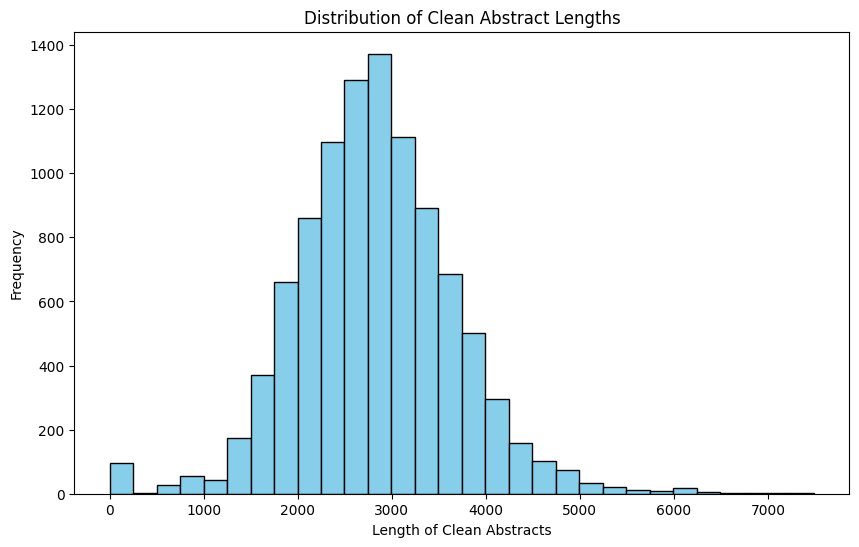

count    9975.000000
mean     2824.123810
std       844.138625
min         0.000000
25%      2301.000000
50%      2804.000000
75%      3323.000000
max      7491.000000
Name: abstract_length, dtype: float64

In [15]:
# Calculate the length of clean abstracts
df_abstracts['abstract_length'] = df_abstracts['clean_abstract'].apply(len)

# Show the distribution of lengths
plt.figure(figsize=(10, 6))
plt.hist(df_abstracts['abstract_length'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Length of Clean Abstracts')
plt.ylabel('Frequency')
plt.title('Distribution of Clean Abstract Lengths')
plt.show()

# Calculate descriptive statistics of the length of abstracts
abstract_length_stats = df_abstracts['abstract_length'].describe()
display(abstract_length_stats)


In [16]:
# # Lista adicional de stop words
# additional_stop_words = ['project', 'research', 'new', 'review', 'criteria', 'use', 'understanding', 'study', 'used', 'including', 'high', 'methods', 'university', 'different',
#                            'results', 'important', 'goal'] 

# # Combinar las stop words en inglés con las adicionales
# combined_stop_words = list(set(CountVectorizer(stop_words='english').get_stop_words()).union(additional_stop_words))

# ###### No lo vi necesario

In [17]:
# Setting CountVectorizer to extract the most frequent words
vectorizer = CountVectorizer(stop_words='english', max_features=30)
data_vectorized = vectorizer.fit_transform(df_abstracts['clean_abstract'])
frequent_words = vectorizer.get_feature_names_out()
# print(frequent_words)

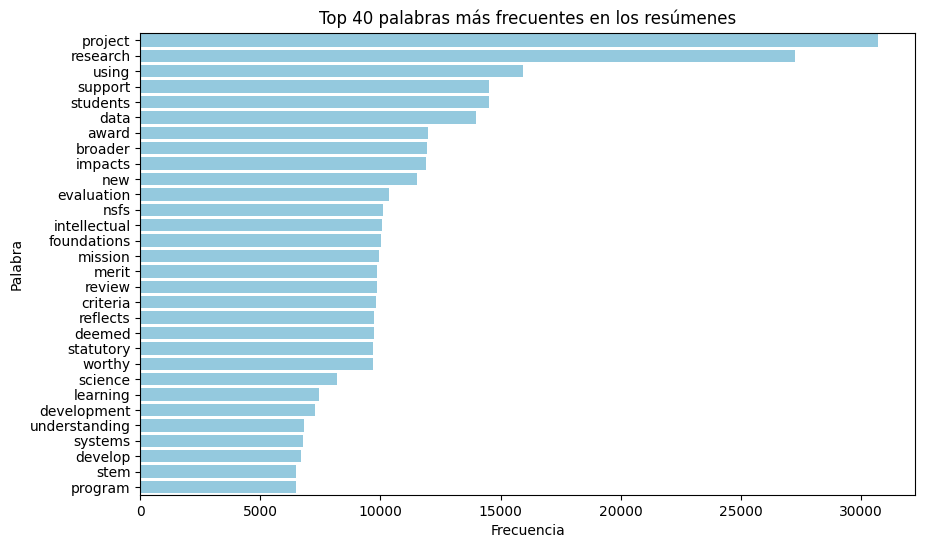

In [18]:
# Add the frequencies of each word
sum_words = data_vectorized.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Create a DataFrame with the most common words
df_words = pd.DataFrame(words_freq, columns=['word', 'freq'])

# Display of the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x='freq', y='word', data=df_words, color='skyblue')
plt.title('Top 40 palabras más frecuentes en los resúmenes')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

#### Analysis
- In general the abstracts are not that different, most are between 2k and 3.5k words. Except for some atypical ones that have few or no words in the xml format.
- The 30 most relevant words seem to be quite decisive about the topics being talked about.
 - Except for some words like *['project', 'research', 'new', 'review', 'criteria', 'use', 'understanding', 'study', 'used', 'including', 'high' , 'methods', 'university', 'different', 'results', 'important', 'goal']* that are often used generically in academic research.
- Taking the 75th percentile of the total number of words to do the embedding, ranking them with tfidf we would have a total of 3323 features for the model
 - It must be clarified how sparse the matrix that is generated is

#### Modelo

In [19]:
# set TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=3, max_features=3323, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_abstracts['clean_abstract'])

In [20]:
tfidf

<9975x3323 sparse matrix of type '<class 'numpy.float64'>'
	with 1181482 stored elements in Compressed Sparse Row format>

Número de elementos no cero: 1181482
Densidad: 0.0356


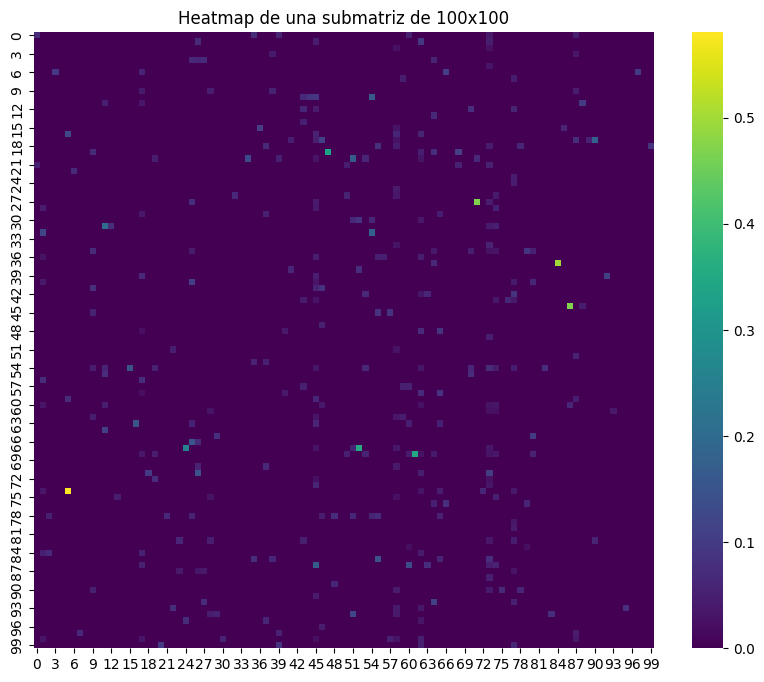

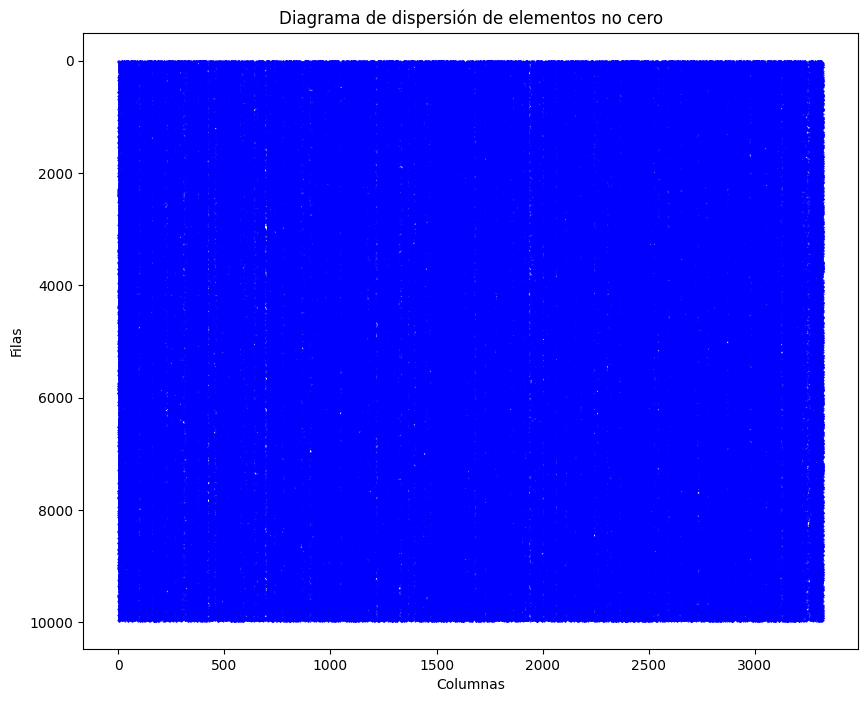

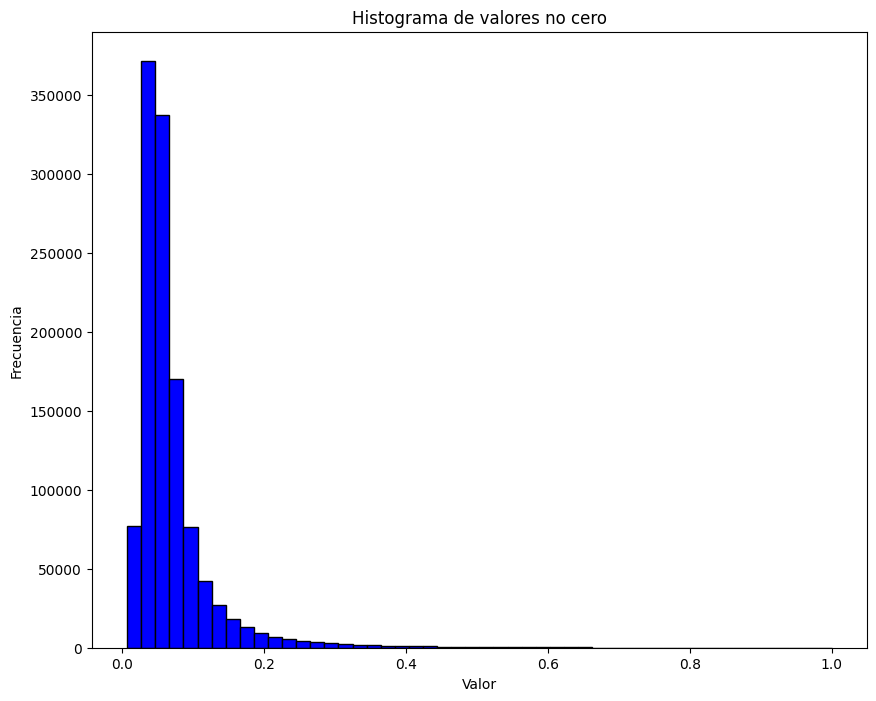

In [21]:
# Statistical summary
rows, cols = tfidf.shape
num_nonzeros = tfidf.count_nonzero()
density = num_nonzeros / (rows * cols)
print(f"Número de elementos no cero: {num_nonzeros}")
print(f"Densidad: {density:.4f}")

# Submatrix for heatmap
submatrix_size = 100 # Size of the submatrix
submatrix = tfidf[:submatrix_size, :submatrix_size].toarray()

plt.figure(figsize=(10, 8))
sns.heatmap(submatrix, cmap='viridis', cbar=True)
plt.title('Heatmap de una submatriz de 100x100')
plt.show()

# Scatterplot of non-zero elements
row, col = tfidf.nonzero()
plt.figure(figsize=(10, 8))
plt.scatter(col, row, marker='.', color='blue', s=1)
plt.gca().invert_yaxis()
plt.title('Diagrama de dispersión de elementos no cero')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.show()

# Histogram of non-zero values
plt.figure(figsize=(10, 8))
plt.hist(tfidf.data, bins=50, color='blue', edgecolor='black')
plt.title('Histograma de valores no cero')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

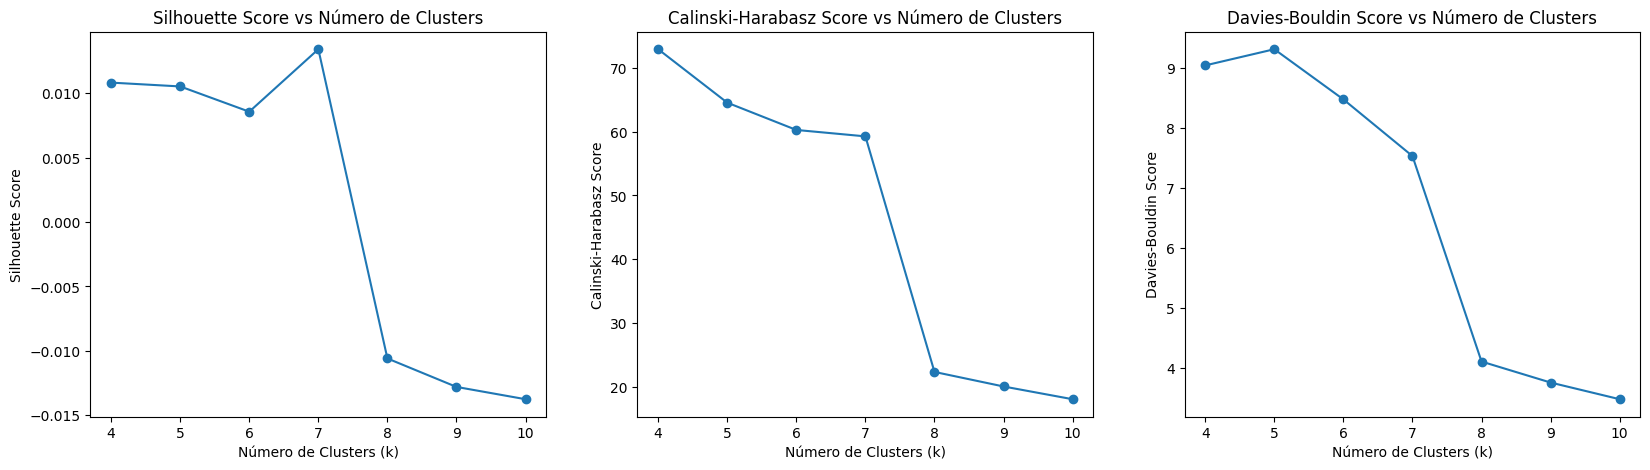

In [22]:
## Analysis of k optimal clusters
cl = Cluster()

cl.find_optimal_k(tfidf, start_k=4, end_k=10, random_state=42)

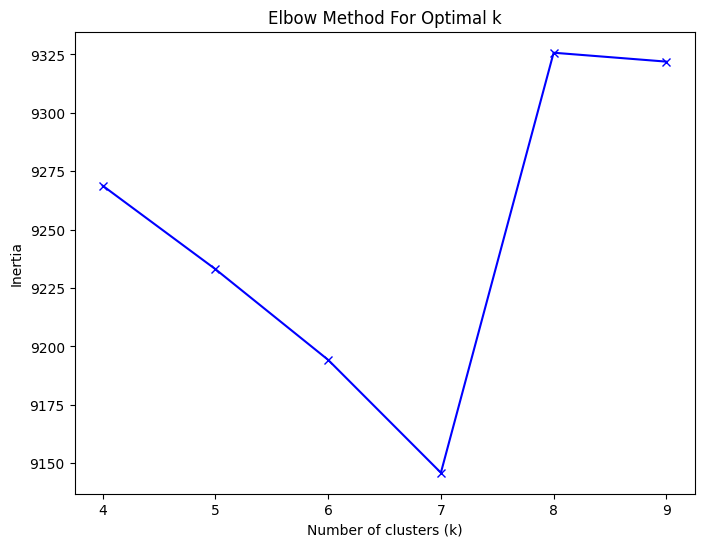

In [23]:
# Elbow method
inertias = []
K = range(4, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(tfidf)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

**The Silhouette score:**
When measuring the similarity between the points of the same cluster vs those of other clusters we have that the best performance is given to the 7 clusters

**Calinski-Harabasz Score:** By measuring the internal dispersion of each cluster compared to the dispersion between clusters with this statistic it gives us an optimal point in 7 clusters

**Davies-Bouldin Score:** When measuring the internal dispersion of the cluster in comparison to the average dispersion between clusters (centroids) with this statistic we have that the optimal point is 5 clusters, however the value of the 7 clusters, which is The one that has performed best in the other statistics is not that far from the optimum of 5.

**Conclusion:** 7 clusters are chosen as the optimal one in this exercise

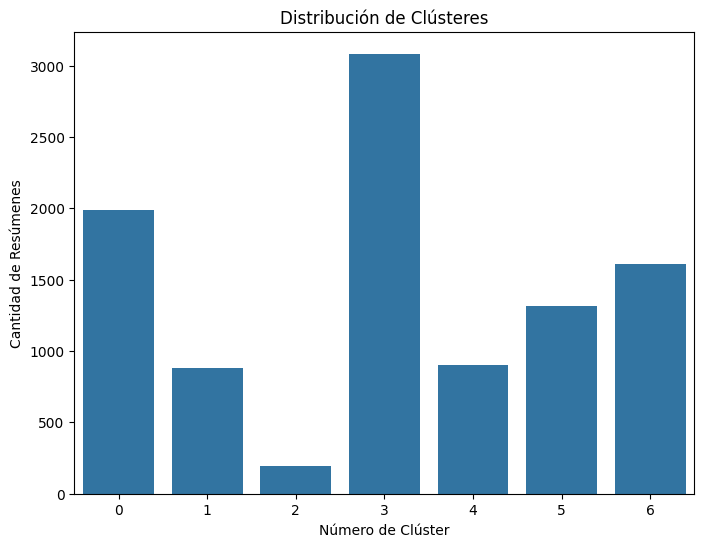

,title,cluster
0,NSF Postdoctoral Fellowship in Biology FY 2020,0
1,PFI-TT: Bridging the Information Gap in Supply...,4
2,Mechanisms of viral protein trafficking in pol...,6
3,Preparing Secondary Teachers to Teach Quantum ...,2
4,FoMR: Microarchitecture mechanisms for handlin...,3


In [24]:
# Configure K-Means
k = 7 # Number of clusters, can be adjusted as needed
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf)

# Assign the clusters to each summary
df_abstracts['cluster'] = kmeans.labels_

# Visualization of cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=df_abstracts)
plt.title('Distribución de Clústeres')
plt.xlabel('Número de Clúster')
plt.ylabel('Cantidad de Resúmenes')
plt.show()

df_abstracts[['title', 'cluster']].head()


In [14]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(tfidf, kmeans.labels_)

# Extract keywords for each cluster
def get_top_keywords(n_terms):
    df_clusters_keywords = pd.DataFrame()
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(k):
        center_terms = kmeans.cluster_centers_[i]
        sorted_terms = center_terms.argsort()[-n_terms:]
        df_clusters_keywords[f"Cluster {i}"] = terms[sorted_terms]
    return df_clusters_keywords

# Get the keywords from the clusters
top_keywords = get_top_keywords(20)  # Shows the top 20 keywords per cluster

display(top_keywords)


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,new,matter,dots,software,develop,teaching,design
1,study,models,magnetic,science,disease,practices,manufacturing
2,students,galaxies,science,analysis,virus,experiences,protein
3,soil,students,light,develop,detection,undergraduate,fundamental
4,plant,mathematics,electrons,computing,device,university,structures
5,processes,applications,properties,machine,treatment,community,understanding
6,arctic,analysis,classical,design,development,college,molecules
7,ice,universe,entanglement,health,icorps,mathematics,high
8,global,stars,states,methods,sarscov,development,mechanical
9,marine,new,new,information,patients,professional,proteins


| Cluster  | Título                                    | Descripción                                                                                                                                      | Palabras más valiosas                         |
|----------|-------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------|
| Cluster 0| Medio Ambiente y Estudios de Ecosistemas  | Este conjunto de papers se centra en temas relacionados con el medio ambiente, el cambio climático y los ecosistemas, especialmente en regiones árticas y marinas. Los estudios abordan procesos ambientales, el impacto del cambio climático y la comprensión de los ecosistemas. | new, study, students, soil, plant             |
| Cluster 1| Matemáticas y Modelos Teóricos            | Este conjunto se enfoca en modelos matemáticos, aplicaciones algebraicas y análisis geométricos. Los estudios pueden involucrar teorías matemáticas avanzadas y su aplicación en la ciencia y la tecnología. | matter, models, galaxies, students, mathematics |
| Cluster 2| Física de Materiales y Ciencia Cuántica   | Papers sobre propiedades magnéticas, entanglement cuántico y el comportamiento de materiales a nivel cuántico. Los estudios exploran dispositivos y fenómenos físicos fundamentales. | dots, magnetic, science, light, electrons     |
| Cluster 3| Ciencia de la Computación y TI            | Enfocado en el desarrollo de software, análisis de datos, redes y algoritmos. Los trabajos tratan sobre el diseño de sistemas computacionales y métodos de aprendizaje. | software, science, analysis, develop, computing |
| Cluster 4| Salud y Ciencias Biomédicas               | Este conjunto aborda el desarrollo de tratamientos para enfermedades, estudios sobre virus y la innovación en dispositivos médicos. Se destacan temas relacionados con la pandemia y la salud pública. | develop, disease, virus, detection, device    |
| Cluster 5| Educación y Prácticas Pedagógicas         | Papers sobre métodos de enseñanza, experiencias educativas y desarrollo profesional en contextos universitarios. Los estudios incluyen tanto la enseñanza de ciencias como el desarrollo de programas educativos. | teaching, practices, experiences, undergraduate, university |
| Cluster 6| Ciencia de Materiales y Química           | Concentrado en el diseño y la comprensión de estructuras moleculares, proteínas y materiales químicos. Los estudios incluyen investigaciones sobre energía, materiales químicos y células. | design, manufacturing, protein, fundamental, structures |


In [25]:
df_abstracts[['clean_abstract','cluster']].groupby(['cluster']).count()
## Note: 1 is mixed a little with 6 and 4
### 4 and 3 are also relatively close
### 5, 0 and 2 are definitely very different in semantics from the other clusters

,clean_abstract
cluster,
0,1990
1,884
2,195
3,3084
4,902
5,1313
6,1607


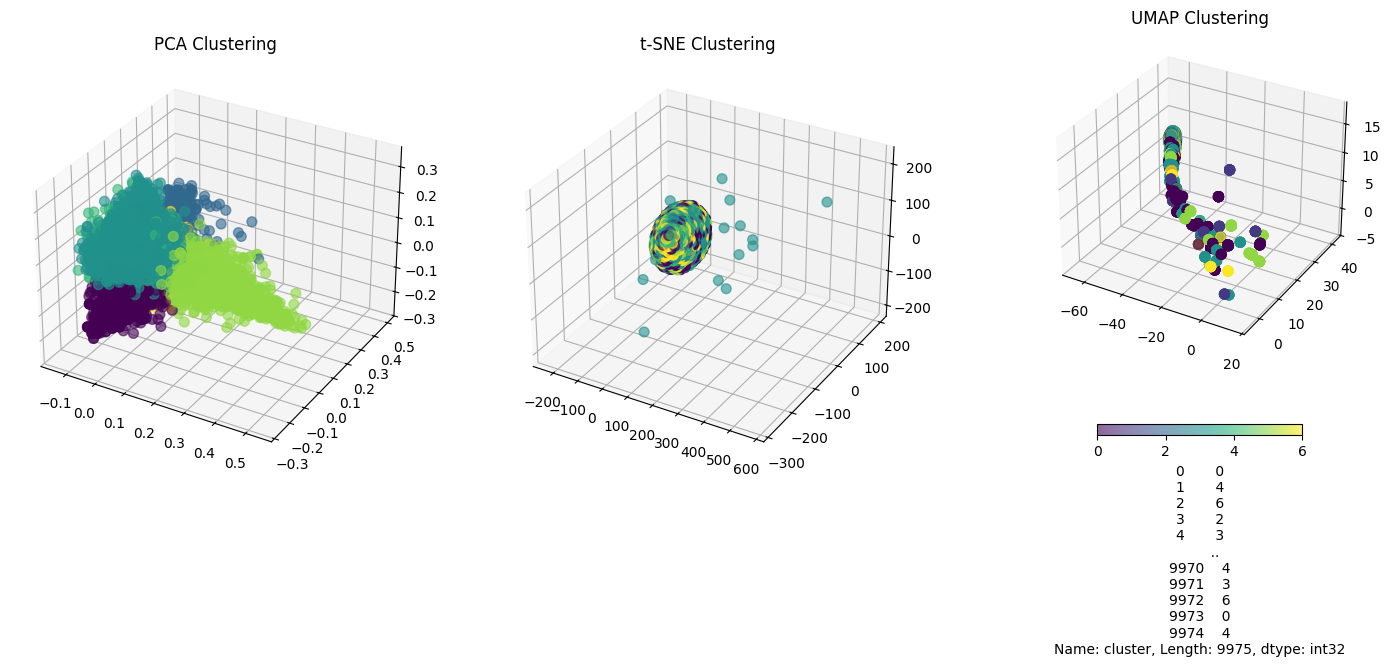

In [26]:
cl.visualize_clusters_3d(tfidf, df_abstracts["cluster"],df_abstracts["cluster"],best_k=7)

In [27]:
# Reduce dimensionality to 3D for visualization
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(tfidf.toarray())

# Create a DataFrame for display
df_viz = pd.DataFrame(reduced_features, columns=['PC1', 'PC2', 'PC3'])
df_viz['cluster'] = kmeans.labels_

# Get the number of points in each cluster
cluster_counts = df_viz['cluster'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['cluster', 'count']

# Merge cluster_counts with df_viz
df_viz = pd.merge(df_viz, cluster_counts, on='cluster')

# Scatter plot of 3D clusters using Plotly
fig = px.scatter_3d(
        df_viz, x='PC1', y='PC2', z='PC3', color='cluster',  title='Visualización de los Clústeres con PCA en 3D',
        labels={
            'PC1': 'Componente Principal 1', 
            'PC2': 'Componente Principal 2', 
            'PC3': 'Componente Principal 3'
        },
        hover_data={'cluster': True, 'count': True}, color_continuous_scale=px.colors.qualitative.Set1)

# Add title and tags
fig.update_traces(marker=dict(size=3), selector=dict(mode='markers'))
fig.update_layout(
        scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend_title='Cluster'
)

fig.show()

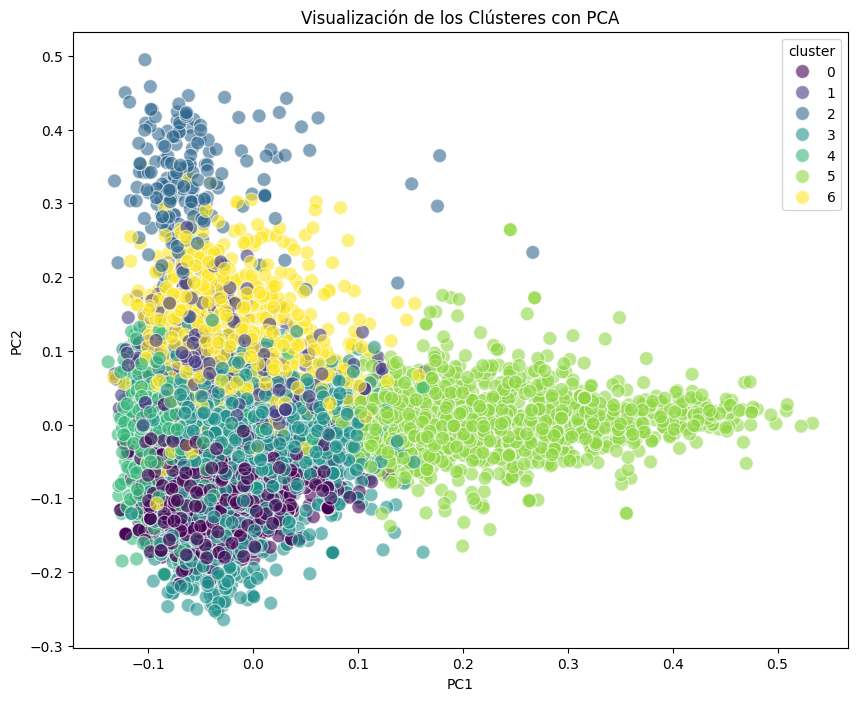

In [28]:
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf.toarray())

# Create a DataFrame for display
df_viz = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
df_viz['cluster'] = kmeans.labels_

# Cluster scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=df_viz, s=100, alpha=0.6)
plt.title('Visualización de los Clústeres con PCA')
plt.show()

In [29]:
print(f"Inertia: {kmeans.inertia_}")

Inertia: 9145.933407505574


In [27]:
# Save the model to a file
joblib.dump(kmeans, 'C:/Users/user/Desktop/Globant/nfs-npl-globant-test-2024/src/models/kmeans_model.pkl')

['kmeans_model.pkl']